In [1]:
import time
import os
import sys
import random
import numpy as np
import pandas as pd 
import h5py
import json
import pickle
import anndata
import scanpy as sc
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import glob
import scprep as scp
import anndata as ad
import seaborn as sns
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from window_adata import *

from tqdm import tqdm
from scipy.stats import pearsonr,spearmanr
from scipy import stats
from torch.utils.data import DataLoader
from copy import deepcopy as dcp
from collections import defaultdict as dfd
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from matplotlib.image import imread
from scanpy import read_visium, read_10x_mtx
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None
from anndata import read as read_h5ad
from pathlib import Path, PurePath
from typing import Union, Dict, Optional, Tuple, BinaryIO
from matplotlib.image import imread
from anndata import (
    AnnData,
    read_csv,
    read_text,
    read_excel,
    read_mtx,
    read_loom,
    read_hdf,)


In [2]:
""" Integrate two visium datasets """
data_dir1 = "./Alex_NatGen_6BreastCancer/"
data_dir2 = "./breast_cancer_10x_visium/"

samps1 = ["1142243F", "CID4290", "CID4465", "CID44971", "CID4535", "1160920F"]
samps2 = ["block1", "block2", "FFPE", "1168993F"]

sampsall = samps1 + samps2
samples1 = {i:data_dir1 + i for i in samps1}
samples2 = {i:data_dir2 + i for i in samps2}

# Marker gene list
gene_list = ["COX6C","TTLL12", "HSP90AB1", "TFF3", "ATP1A1", "B2M", "FASN", "SPARC", "CD74", "CD63", "CD24", "CD81"]



In [3]:
# Load windowed dataset
import pickle
with open('/scratch/imb/uqyjia11/Yuanhao/10X_visium/CNN_GAT/10x_visium_dataset_without_window.pickle', 'rb') as f:
    adata_dict0 = pickle.load(f)
    
# Define the gridding size
sizes = [4000 for i in range(len(adata_dict0))]

# Split tiles into smaller patches according to gridding size
adata_dict = window_adata(adata_dict0, sizes)

Windowing 1142243F
Num spots:  4784
246
216
222
185
77
247
246
255
247
93
246
247
255
245
94
247
246
255
238
88
130
135
132
140
55
Total:  4787
Windowing CID4290
Num spots:  2714
793
576
1001
344
Total:  2714
Windowing CID4465
Num spots:  1310
345
258
149
558
Total:  1310
Windowing CID44971
Num spots:  1322
491
462
339
30
Total:  1322
Windowing CID4535
Num spots:  1431
564
232
632
3
Total:  1431
Windowing 1160920F
Num spots:  4895
210
251
251
239
83
226
255
232
240
102
231
230
246
247
99
238
246
247
255
93
144
147
164
160
60
Total:  4896
Windowing block1
Num spots:  3798
139
205
219
185
10
169
246
247
255
16
189
230
205
233
0
197
156
241
228
0
72
106
129
124
0
Total:  3801
Windowing block2
Num spots:  3987
224
247
246
229
208
246
247
231
243
207
211
196
221
195
254
205
81
97
108
92
Total:  3988
Windowing FFPE
Num spots:  2518
50
190
188
79
0
169
219
216
189
0
182
215
201
192
0
68
138
159
63
0
0
1
0
0
0
Total:  2519
Windowing 1168993F
Num spots:  4898
244
249
248
244
68
246
247
255
246


In [5]:
# For training
from data_vit import ViT_Anndata

# set random seed
def setup_seed(seed=12000):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    
def dataset_wrap(dataloader= True):
    train_sample = list(set(samps1)-set(["1160920F","CID4290"]))
    tr_name = list(set([i for i in list(adata_dict.keys()) for tr in train_sample if tr in i]))
    trainset = ViT_Anndata(adata_dict, tr_name, gene_list)
    print("LOADED TRAINSET")
    train_loader = DataLoader(trainset, batch_size=1, num_workers=0, shuffle=True)
    if dataloader==True:
        return train_loader
    else:
        return trainset
    

In [6]:
import gc
from data_vit import ViT_Anndata
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import time

start_time = time.time()

"""Load dataset"""
# train_loader, val_loader, test_loader = dataset_wrap(dataloader= True)
train_loader = dataset_wrap(dataloader= True)


Eval set:  ['1142243F_6', '1142243F_23', '1142243F_17', 'CID4465_3', '1142243F_14', '1142243F_5', '1142243F_19', 'CID4535_1', '1142243F_0', '1142243F_16', 'CID4535_2', '1142243F_11', '1142243F_7', 'CID4535_0', 'CID4465_2', '1142243F_15', '1142243F_22', 'CID4465_0', '1142243F_12', 'CID44971_3', 'CID44971_0', 'CID44971_2', '1142243F_4', '1142243F_21', '1142243F_20', '1142243F_9', 'CID4465_1', '1142243F_24', '1142243F_8', 'CID44971_1', '1142243F_1', '1142243F_2', '1142243F_10', '1142243F_13', '1142243F_3', '1142243F_18']
Loading imgs...
LOADED TRAINSET


# Augmentaion methods across softwares

Summary of Data Augmentation Methods across the softwares.

Geometric transformations:
* RandomFlip
* RandomRoation
* RandomResizedCrop
* RandomErasing

Color space transformations:
* RandomGrayscale
* ColorJitter
* GaussianBlur

In [7]:
""" Create augmentaion methods by softwares """

import albumentations as albu
import torchvision.transforms as tf

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
aug_software = {}

methods = ["ST-net", "HistoGene", "Hist2ST", "STimage", "BLEEP", "randaug", "autoaug"]
for method in methods:
    if method=="ST-net":
        aug_software[method] = tf.Compose([tf.RandomHorizontalFlip(),
                          tf.RandomVerticalFlip(),
                          tf.RandomApply([torchvision.transforms.RandomRotation((90, 90))]), ]) 
        
    elif method=="HistoGene":
        aug_software[method] = tf.Compose([
            tf.ColorJitter(0.5,0.5,0.5),
            tf.RandomHorizontalFlip(),
            tf.RandomRotation(degrees=180),
        ])
        
    elif method=="Hist2ST":
        aug_software[method] = tf.Compose([
                tf.RandomGrayscale(0.1),
                tf.RandomRotation(90),
                tf.RandomHorizontalFlip(0.2),
            ])
        
#     elif method=="DeepSpace":
#         aug_software[method] = albu.Compose([
#                 albu.RandomRotate90(p=0.5),
#                 albu.Flip(p=0.5),
#                 albu.Transpose(p=0.5),
#                 albu.RandomResizedCrop(height=size, width=size, scale=(0.5, 1.0), p=0.5),
#                 albu.HueSaturationValue(p=0.5),
#                 albu.ChannelShuffle(p=0.5),
#                 albu.RGBShift(p=0.5),])
                    
    elif method=="BLEEP":
        # Random flipping and rotations
        angle = random.choice([180, 90, 0, 270])
        aug_software[method] = tf.Compose([
                tf.RandomRotation(angle),
                tf.RandomHorizontalFlip(0.5),
                tf.RandomVerticalFlip(0.5),
            ])
    elif method=="STimage":
        class AddGaussianNoise(object):
            def __init__(self, mean=0., std=1.):
                self.std = std
                self.mean = mean

            def __call__(self, tensor):
                return tensor + torch.randn(tensor.size()) * self.std + self.mean

            def __repr__(self):
                return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
            
        stimage = tf.Compose([
            tf.RandomHorizontalFlip(0.5),
            tf.RandomVerticalFlip(0.5),
            tf.RandomApply([tf.RandomAffine(degrees=(-45,45), scale=(0.8, 1.2)),
                           tf.RandomGrayscale(0.5),
                           tf.GaussianBlur(1, np.random.rand() * 1.9 + 0.1),
                           tf.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)
                           ], p=0.5,), ])
        def stimage_aug(x):
            aug_img = stimage(x.to(torch.uint8))
            return aug_img.to(torch.float32)
        aug_software[method] = stimage_aug
        
    elif method=="randaug":
        def randaug(x):
            aug_img = tf.RandAugment()(x.to(torch.uint8))
            return aug_img.to(torch.float32)
        aug_software[method] = randaug
            
    elif method=="autoaug":
        def autoaug(x):
            aug_img = tf.AutoAugment()(x.to(torch.uint8))
            return aug_img.to(torch.float32)
        aug_software[method] = autoaug



In [8]:
""" Hist2ST model """
import torch
import numpy as np
import pytorch_lightning as pl
import torchvision.transforms as tf
from gcn import *
from NB_module import *
from transformer import *
from scipy.stats import pearsonr
from torch.utils.data import DataLoader
from copy import deepcopy as dcp
from collections import defaultdict as dfd
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

class convmixer_block(nn.Module):
    def __init__(self,dim,kernel_size):
        super().__init__()
        self.dw=nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                nn.BatchNorm2d(dim),
                nn.GELU(),
                nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                nn.BatchNorm2d(dim),
                nn.GELU(),
        )
        self.pw=nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=1),
            nn.GELU(),
            nn.BatchNorm2d(dim),
        )
    def forward(self,x):
        x=self.dw(x)+x
        x=self.pw(x)
        return x
    
class mixer_transformer(nn.Module):
    def __init__(self,channel=32, kernel_size=5, dim=1024,
                 depth1=2, depth2=8, depth3=4, 
                 heads=8, dim_head=64, mlp_dim=1024, dropout = 0.,
                 policy='mean',gcn=True
                ):
        super().__init__()
        self.layer1=nn.Sequential(
            *[convmixer_block(channel,kernel_size) for i in range(depth1)],
        )
        self.layer2=nn.Sequential(*[attn_block(dim,heads,dim_head,mlp_dim,dropout) for i in range(depth2)])
        self.layer3=nn.ModuleList([gs_block(dim,dim,policy,gcn) for i in range(depth3)])
        self.jknet=nn.Sequential(
            nn.LSTM(dim,dim,2),
            SelectItem(0),
        )
        self.down=nn.Sequential(
            nn.Conv2d(channel,channel//8,1,1),
            nn.Flatten(),
        )
    def forward(self,x,ct,adj):
        x=self.down(self.layer1(x))
        g=x.unsqueeze(0)
        g=self.layer2(g+ct).squeeze(0)
        jk=[]
        for layer in self.layer3:
            g=layer(g,adj)
            jk.append(g.unsqueeze(0))
        g=torch.cat(jk,0)
        g=self.jknet(g).mean(0)
        return g
    
class ViT(nn.Module):
    def __init__(self, channel=32,kernel_size=5,dim=1024, 
                 depth1=2, depth2=8, depth3=4, 
                 heads=8, mlp_dim=1024, dim_head = 64, dropout = 0.,
                 policy='mean',gcn=True
                ):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.transformer = mixer_transformer(
            channel, kernel_size, dim, 
            depth1, depth2, depth3, 
            heads, dim_head, mlp_dim, dropout,
            policy,gcn,
        )

    def forward(self,x,ct,adj):
        x = self.dropout(x)
        x = self.transformer(x,ct,adj)
        return x

class Hist2ST(pl.LightningModule):
    def __init__(self, learning_rate=1e-5, fig_size=112, label=None, 
                 dropout=0.2, n_pos=128, kernel_size=5, patch_size=7, n_genes=785, 
                 depth1=2, depth2=8, depth3=4, heads=16, channel=32, 
                 zinb=0, nb=False, bake=0, lamb=0, policy='mean', 
                 aug_method="Hist2ST", aug_software=aug_software,
                ):
        super().__init__()
        # self.save_hyperparameters()
        dim=(fig_size//patch_size)**2*channel//8
        self.learning_rate = learning_rate
        
        self.nb=nb
        self.zinb=zinb
        
        self.bake=bake
        self.lamb=lamb
        
        self.label=label
        self.patch_embedding = nn.Conv2d(3,channel,patch_size,patch_size)
        self.x_embed = nn.Embedding(n_pos,dim)
        self.y_embed = nn.Embedding(n_pos,dim)
        self.vit = ViT(
            channel=channel, kernel_size=kernel_size, heads=heads,
            dim=dim, depth1=depth1,depth2=depth2, depth3=depth3, 
            mlp_dim=dim, dropout = dropout, policy=policy, gcn=True,
        )
        self.channel=channel
        self.patch_size=patch_size
        self.n_genes=n_genes
        if self.zinb>0:
            if self.nb:
                self.hr=nn.Linear(dim, n_genes)
                self.hp=nn.Linear(dim, n_genes)
            else:
                self.mean = nn.Sequential(nn.Linear(dim, n_genes), MeanAct())
                self.disp = nn.Sequential(nn.Linear(dim, n_genes), DispAct())
                self.pi = nn.Sequential(nn.Linear(dim, n_genes), nn.Sigmoid())
        if self.bake>0:
            self.coef=nn.Sequential(
                nn.Linear(dim,dim),
                nn.ReLU(),
                nn.Linear(dim,1),
            )
        self.gene_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, n_genes),
        )
        
        self.tf = aug_software[aug_method]
        
        
    def forward(self, patches, centers, adj, aug=False):
        B,N,C,H,W=patches.shape
        patches=patches.reshape(B*N,C,H,W)
        patches = self.patch_embedding(patches)
        centers_x = self.x_embed(centers[:,:,0])
        centers_y = self.y_embed(centers[:,:,1])
        ct=centers_x + centers_y
        h = self.vit(patches,ct,adj)
        x = self.gene_head(h)
        extra=None
        if self.zinb>0:
            if self.nb:
                r=self.hr(h)
                p=self.hp(h)
                extra=(r,p)
            else:
                m = self.mean(h)
                d = self.disp(h)
                p = self.pi(h)
                extra=(m,d,p)
        if aug:
            h=self.coef(h)
        return x,extra,h
    
    def aug(self,patch,center,adj):
        bake_x=[]
        for i in range(self.bake):
            new_patch=self.tf(patch.squeeze(0)).unsqueeze(0)
            x,_,h=self(new_patch,center,adj,True)
            bake_x.append((x.unsqueeze(0),h.unsqueeze(0)))
        return bake_x
    
    def distillation(self,bake_x):
        new_x,coef=zip(*bake_x)
        coef=torch.cat(coef,0)
        new_x=torch.cat(new_x,0)
        coef=F.softmax(coef,dim=0)
        new_x=(new_x*coef).sum(0)
        return new_x
    
    def training_step(self, batch, batch_idx):
        patch, center, exp, adj, oris, sfs, *_ = batch
        adj=adj.squeeze(0)
        exp=exp.squeeze(0)
        pred,extra,h = self(patch, center, adj, True)
        
        mse_loss = F.mse_loss(pred, exp)
        self.log('mse_loss', mse_loss,on_epoch=True, prog_bar=True, logger=True)
        bake_loss=0
        if self.bake>0:
            bake_x=self.aug(patch,center,adj)
            new_pred=self.distillation(bake_x)
            bake_loss+=F.mse_loss(new_pred,pred)
            self.log('bake_loss', bake_loss,on_epoch=True, prog_bar=True, logger=True)
        zinb_loss=0
        if self.zinb>0:
            if self.nb:
                r,p=extra
                zinb_loss = NB_loss(oris.squeeze(0),r,p)
            else:
                m,d,p=extra
                zinb_loss = ZINB_loss(oris.squeeze(0),m,d,p,sfs.squeeze(0))
            self.log('zinb_loss', zinb_loss,on_epoch=True, prog_bar=True, logger=True)
            
        loss=mse_loss+self.zinb*zinb_loss+self.lamb*bake_loss
        self.log('Train_loss', loss,on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        patch, center, exp, adj, oris, sfs, *_ = batch
        def cluster(pred,cls):
            sc.pp.pca(pred)
            sc.tl.tsne(pred)
            kmeans = KMeans(n_clusters=cls, init="k-means++", random_state=0).fit(pred.obsm['X_pca'])
            pred.obs['kmeans'] = kmeans.labels_.astype(str)
            p=pred.obs['kmeans'].to_numpy()
            return p
        
        pred,extra,h = self(patch, center, adj.squeeze(0))
        
        loss = F.mse_loss(pred.squeeze(0), exp.squeeze(0))
        self.log('val_loss', loss,on_epoch=True, prog_bar=True, logger=True)
        
        pred=pred.squeeze(0).cpu().numpy().T
        exp=exp.squeeze(0).cpu().numpy().T
        r=[]
        for g in range(self.n_genes):
            r.append(pearsonr(pred[g],exp[g])[0])
        R=torch.Tensor(r).mean()
        self.log('R', R, on_epoch=True, prog_bar=True, logger=True)
        return R
    
    def test_step(self, batch, batch_idx):
        patch, center, exp, adj, oris, sfs, *_ = batch
        def cluster(pred,cls):
            sc.pp.pca(pred)
            sc.tl.tsne(pred)
            kmeans = KMeans(n_clusters=cls, init="k-means++", random_state=0).fit(pred.obsm['X_pca'])
            pred.obs['kmeans'] = kmeans.labels_.astype(str)
            p=pred.obs['kmeans'].to_numpy()
            return p
        
        pred,extra,h = self(patch, center, adj.squeeze(0))
        
        pred=pred.squeeze(0).cpu().numpy().T
        exp=exp.squeeze(0).cpu().numpy().T
        r=[]
        for g in range(self.n_genes):
            r.append(pearsonr(pred[g],exp[g])[0])
        R=torch.Tensor(r).mean()
        self.log('R', R, on_epoch=True, prog_bar=True, logger=True)
        return R

    def configure_optimizers(self):
        # self.hparams available because we called self.save_hyperparameters()
        optim=torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        StepLR = torch.optim.lr_scheduler.StepLR(optim, step_size=50, gamma=0.9)
        optim_dict = {'optimizer': optim, 'lr_scheduler': StepLR}
        return optim_dict

[easydl] tensorflow not available!


In [9]:
"""Training loops"""
seed=12000
epochs=1

methods = ["ST-net", "HistoGene", "Hist2ST", "STimage", "BLEEP", "autoaug", "randaug"]

for i in range(len(methods)):
    """Define model"""
    aug_method=methods[i]
    
    model = Hist2ST(
        depth1=2, depth2=8, depth3=4,
        n_genes=12, learning_rate=1e-5,
        kernel_size=5, patch_size=7, fig_size=112,
        heads=16, channel=32, dropout=0.2,
        zinb=0.25, nb=False,
        bake=5, lamb=0.5, 
        policy='mean', aug_method=methods[i],
    )
    setup_seed(12000)

    """Setup trainer"""
    import os
    # if not os.path.exists('./training_curve'):
    #     os.makedirs('./training_curve')
    # logger = pl.loggers.CSVLogger("logs", name=f"./training_curve/{aug_method}")
    trainer = pl.Trainer(accelerator='auto',  callbacks=[EarlyStopping(monitor='Train_loss',mode='min')], max_epochs=epochs, logger=False)
    trainer.fit(model, train_loader)

    """Save model and clean memory"""
#     if not os.path.exists('./model'):
#         os.makedirs('./model')
#     torch.save(model.state_dict(),f"./model/{aug_method}-seed{seed}-epochs{epochs}.ckpt")
    del model
    gc.collect()
    end_time = time.time()
    execution_time = end_time - start_time
    print("Training time: ", execution_time/3600, " hours")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | patch_embedding | Conv2d     | 4.7 K 
1 | x_embed         | Embedding  | 131 K 
2 | y_embed         | Embedding  | 131 K 
3 | vit             | ViT        | 71.4 M
4 | mean            | Sequential | 12.3 K
5 | disp            | Sequential | 12.3 K
6 | pi              | Sequential | 12.3 K
7 | coef            | Sequential | 1.1 M 
8 | gene_head       | Sequential | 14.3 K
-----------------------------------------------
72.8 M    Trainable params
0         Non-trainable params
72.8 M    Total params
291.006   Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 0: 100%|██████████| 36/36 [03:22<00:00,  5.61s/it, mse_loss_step=1.500, bake_loss_step=0.000101, zinb_loss_step=6.520, Train_loss_step=3.130, mse_loss_epoch=3.300, bake_loss_epoch=0.000139, zinb_loss_epoch=5.680, Train_loss_epoch=4.720]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 36/36 [03:23<00:00,  5.65s/it, mse_loss_step=1.500, bake_loss_step=0.000101, zinb_loss_step=6.520, Train_loss_step=3.130, mse_loss_epoch=3.300, bake_loss_epoch=0.000139, zinb_loss_epoch=5.680, Train_loss_epoch=4.720]
Training time:  0.07016754580868614  hours


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | patch_embedding | Conv2d     | 4.7 K 
1 | x_embed         | Embedding  | 131 K 
2 | y_embed         | Embedding  | 131 K 
3 | vit             | ViT        | 71.4 M
4 | mean            | Sequential | 12.3 K
5 | disp            | Sequential | 12.3 K
6 | pi              | Sequential | 12.3 K
7 | coef            | Sequential | 1.1 M 
8 | gene_head       | Sequential | 14.3 K
-----------------------------------------------
72.8 M    Trainable params
0         Non-trainable params
72.8 M    Total params
291.006   Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 0: 100%|██████████| 36/36 [00:10<00:00,  3.30it/s, mse_loss_step=1.800, bake_loss_step=0.000176, zinb_loss_step=6.500, Train_loss_step=3.430, mse_loss_epoch=3.860, bake_loss_epoch=0.000226, zinb_loss_epoch=5.660, Train_loss_epoch=5.270]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 36/36 [00:12<00:00,  2.98it/s, mse_loss_step=1.800, bake_loss_step=0.000176, zinb_loss_step=6.500, Train_loss_step=3.430, mse_loss_epoch=3.860, bake_loss_epoch=0.000226, zinb_loss_epoch=5.660, Train_loss_epoch=5.270]
Training time:  0.07393997947374979  hours


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | patch_embedding | Conv2d     | 4.7 K 
1 | x_embed         | Embedding  | 131 K 
2 | y_embed         | Embedding  | 131 K 
3 | vit             | ViT        | 71.4 M
4 | mean            | Sequential | 12.3 K
5 | disp            | Sequential | 12.3 K
6 | pi              | Sequential | 12.3 K
7 | coef            | Sequential | 1.1 M 
8 | gene_head       | Sequential | 14.3 K
-----------------------------------------------
72.8 M    Trainable params
0         Non-trainable params
72.8 M    Total params
291.006   Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 0: 100%|██████████| 36/36 [00:09<00:00,  3.74it/s, mse_loss_step=1.350, bake_loss_step=0.000157, zinb_loss_step=6.490, Train_loss_step=2.970, mse_loss_epoch=3.090, bake_loss_epoch=0.000187, zinb_loss_epoch=5.660, Train_loss_epoch=4.500]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 36/36 [00:10<00:00,  3.29it/s, mse_loss_step=1.350, bake_loss_step=0.000157, zinb_loss_step=6.490, Train_loss_step=2.970, mse_loss_epoch=3.090, bake_loss_epoch=0.000187, zinb_loss_epoch=5.660, Train_loss_epoch=4.500]
Training time:  0.0773428303665585  hours


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | patch_embedding | Conv2d     | 4.7 K 
1 | x_embed         | Embedding  | 131 K 
2 | y_embed         | Embedding  | 131 K 
3 | vit             | ViT        | 71.4 M
4 | mean            | Sequential | 12.3 K
5 | disp            | Sequential | 12.3 K
6 | pi              | Sequential | 12.3 K
7 | coef            | Sequential | 1.1 M 
8 | gene_head       | Sequential | 14.3 K
-----------------------------------------------
72.8 M    Trainable params
0         Non-trainable params
72.8 M    Total params
291.006   Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 0: 100%|██████████| 36/36 [00:11<00:00,  3.19it/s, mse_loss_step=2.020, bake_loss_step=9.69e-5, zinb_loss_step=6.510, Train_loss_step=3.650, mse_loss_epoch=4.220, bake_loss_epoch=0.000145, zinb_loss_epoch=5.660, Train_loss_epoch=5.640]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 36/36 [00:12<00:00,  2.84it/s, mse_loss_step=2.020, bake_loss_step=9.69e-5, zinb_loss_step=6.510, Train_loss_step=3.650, mse_loss_epoch=4.220, bake_loss_epoch=0.000145, zinb_loss_epoch=5.660, Train_loss_epoch=5.640]
Training time:  0.08118368983268738  hours


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | patch_embedding | Conv2d     | 4.7 K 
1 | x_embed         | Embedding  | 131 K 
2 | y_embed         | Embedding  | 131 K 
3 | vit             | ViT        | 71.4 M
4 | mean            | Sequential | 12.3 K
5 | disp            | Sequential | 12.3 K
6 | pi              | Sequential | 12.3 K
7 | coef            | Sequential | 1.1 M 
8 | gene_head       | Sequential | 14.3 K
-----------------------------------------------
72.8 M    Trainable params
0         Non-trainable params
72.8 M    Total params
291.006   Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 0: 100%|██████████| 36/36 [00:10<00:00,  3.49it/s, mse_loss_step=1.500, bake_loss_step=0.000183, zinb_loss_step=6.540, Train_loss_step=3.130, mse_loss_epoch=3.310, bake_loss_epoch=0.000207, zinb_loss_epoch=5.690, Train_loss_epoch=4.730]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 36/36 [00:11<00:00,  3.12it/s, mse_loss_step=1.500, bake_loss_step=0.000183, zinb_loss_step=6.540, Train_loss_step=3.130, mse_loss_epoch=3.310, bake_loss_epoch=0.000207, zinb_loss_epoch=5.690, Train_loss_epoch=4.730]
Training time:  0.08472847739855448  hours


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | patch_embedding | Conv2d     | 4.7 K 
1 | x_embed         | Embedding  | 131 K 
2 | y_embed         | Embedding  | 131 K 
3 | vit             | ViT        | 71.4 M
4 | mean            | Sequential | 12.3 K
5 | disp            | Sequential | 12.3 K
6 | pi              | Sequential | 12.3 K
7 | coef            | Sequential | 1.1 M 
8 | gene_head       | Sequential | 14.3 K
-----------------------------------------------
72.8 M    Trainable params
0         Non-trainable params
72.8 M    Total params
291.006   Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 0: 100%|██████████| 36/36 [00:28<00:00,  1.28it/s, mse_loss_step=2.020, bake_loss_step=9.21e-5, zinb_loss_step=6.510, Train_loss_step=3.650, mse_loss_epoch=4.220, bake_loss_epoch=0.000135, zinb_loss_epoch=5.660, Train_loss_epoch=5.640]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 36/36 [00:29<00:00,  1.23it/s, mse_loss_step=2.020, bake_loss_step=9.21e-5, zinb_loss_step=6.510, Train_loss_step=3.650, mse_loss_epoch=4.220, bake_loss_epoch=0.000135, zinb_loss_epoch=5.660, Train_loss_epoch=5.640]
Training time:  0.09321827345424229  hours


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | patch_embedding | Conv2d     | 4.7 K 
1 | x_embed         | Embedding  | 131 K 
2 | y_embed         | Embedding  | 131 K 
3 | vit             | ViT        | 71.4 M
4 | mean            | Sequential | 12.3 K
5 | disp            | Sequential | 12.3 K
6 | pi              | Sequential | 12.3 K
7 | coef            | Sequential | 1.1 M 
8 | gene_head       | Sequential | 14.3 K
-----------------------------------------------
72.8 M    Trainable params
0         Non-trainable params
72.8 M    Total params
291.006   Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 0: 100%|██████████| 36/36 [00:16<00:00,  2.19it/s, mse_loss_step=1.790, bake_loss_step=0.000116, zinb_loss_step=6.520, Train_loss_step=3.420, mse_loss_epoch=3.840, bake_loss_epoch=0.000155, zinb_loss_epoch=5.680, Train_loss_epoch=5.260]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s, mse_loss_step=1.790, bake_loss_step=0.000116, zinb_loss_step=6.520, Train_loss_step=3.420, mse_loss_epoch=3.840, bake_loss_epoch=0.000155, zinb_loss_epoch=5.680, Train_loss_epoch=5.260]
Training time:  0.09845522112316556  hours


# Testing

In [8]:
import sys
sys.path.append("./")

import time
from window_adata import *
import os
import sys
import numpy as np
import pandas as pd 
import h5py
import json
import pickle
import anndata
import scanpy as sc
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import glob
import torchvision
import scprep as scp
import anndata as ad
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from tqdm import tqdm
from scipy.stats import pearsonr,spearmanr
from scipy import stats
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
from copy import deepcopy as dcp
from collections import defaultdict as dfd
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from pathlib import Path, PurePath
from typing import Union, Dict, Optional, Tuple, BinaryIO
from matplotlib.image import imread
from scanpy import read_visium, read_10x_mtx
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None
from anndata import read as read_h5ad
from pathlib import Path, PurePath
from typing import Union, Dict, Optional, Tuple, BinaryIO
from matplotlib.image import imread
from anndata import (
    AnnData,
    read_csv,
    read_text,
    read_excel,
    read_mtx,
    read_loom,
    read_hdf,)

""" Integrate two visium datasets """
data_dir1 = "./Alex_NatGen_6BreastCancer/"
data_dir2 = "./breast_cancer_10x_visium/"

samps1 = ["1142243F", "CID4290", "CID4465", "CID44971", "CID4535", "1160920F"]
samps2 = ["block1", "block2", "FFPE"]

sampsall = samps1 + samps2
samples1 = {i:data_dir1 + i for i in samps1}
samples2 = {i:data_dir2 + i for i in samps2}

# Marker gene list
gene_list = ["COX6C","TTLL12", "HSP90AB1", "TFF3", "ATP1A1", "B2M", "FASN", "SPARC", "CD74", "CD63", "CD24", "CD81"]

# # Load windowed dataset
import pickle
with open('/scratch/imb/uqyjia11/Yuanhao/10X_visium/CNN_GAT/10x_visium_dataset_without_window.pickle', 'rb') as f:
    adata_dict0 = pickle.load(f)
    

In [12]:
# For testing
from data_vit import ViT_Anndata

# set random seed
def setup_seed(seed=12000):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    
def dataset_wrap(fold = 0, dataloader= True):
    test_sample = sampsall[fold]
    print(f"Test sample: {test_sample}")
    test_sample_orig = sampsall[fold] # Split one sample as test sample
    te_name = list(set([i for i in list(adata_dict0.keys()) if test_sample in i]))
    testset = ViT_Anndata(adata_dict = adata_dict0, train_set = te_name, gene_list = gene_list, processed_img=None, train=True, flatten=False, ori=True, prune='NA', neighs=4, )
    test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)
    if dataloader==True:
        return test_loader
    else:
        return testset

In [13]:
def test(name, model, test_loader):
    model.eval()
    device = 'cpu'
    for patch, center, exp, adj, oris, sfs, *_ in test_loader:
        adj=adj.squeeze(0)
        exp=exp.squeeze(0)
        ct = center.squeeze().cpu().numpy()
        gts = exp.squeeze().cpu().numpy()

        """Model inference"""
        gene_exp, extra, ft = model(patch, center, adj)
        
        """Put prediction into adata"""
        pred = ad.AnnData(gene_exp.cpu().detach().numpy())
        gene_list = ["COX6C","TTLL12", "HSP90AB1", "TFF3", "ATP1A1", "B2M", "FASN", "SPARC", "CD74", "CD63", "CD24", "CD81"]
        pred.var_names = gene_list
        pred.obsm['spatial'] = ct
        
        """Regression loss"""
        mse_loss = F.mse_loss(gene_exp, exp)
        pred.obs['MSE'] = mse_loss.cpu().detach().numpy()

        """Pearson correlation coeficient"""
        adata1 = ad.AnnData(gene_exp.cpu().detach().numpy())
        adata2 = ad.AnnData(exp.cpu().detach().numpy())
        R=get_R(adata1,adata2)[0]
        mean_pcc=np.nanmean(R)
        pred.var["Pearson correlation"]=R
        print(f"Mean_PCC:{mean_pcc}")
    return pred

In [52]:
"""For debuging only"""
import gc
import time
import random
from predict import get_R
from data_vit import ViT_Anndata
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


start_time = time.time()
"""Training loops"""
"""Training loops"""
seed=12000
epochs=350
methods = ["BLEEP", "autoaug","STimage", "ST-net", "HistoGene", "Hist2ST"]

for aug_method in methods:
    print("aug_method:",aug_method)
    for fold in range(9):
        """print sample name"""
        te_name = sampsall[fold]

        """Reproducibility"""
        setup_seed(seed)

        """Define model"""
        model = Hist2ST(
            depth1=2, depth2=8, depth3=4,
            n_genes=12, learning_rate=1e-5,
            kernel_size=5, patch_size=7, fig_size=112,
            heads=16, channel=32, dropout=0.2,
            zinb=0.25, nb=False,
            bake=5, lamb=0.5, 
            policy='mean', aug_method=aug_method, )
        model.load_state_dict(torch.load(f"./model/{aug_method}-seed{seed}-epochs{epochs}.ckpt"))

        """Load dataset"""
        test_loader = dataset_wrap(fold = fold, dataloader= True)

        """Test model performance"""
        pred = test(te_name, model, test_loader)
        df = pred.var
        df["Gene"] = df.index
        df["Slide"] = te_name
        df["Method"] = f"{aug_method}_Hist2ST"

        import os
        directory = f"./Results/PCC_table"
        if not os.path.exists(directory):
            os.makedirs(directory)

        df.to_csv(f"./Results/PCC_table/PCC_{te_name}_{aug_method}_Hist2ST.csv")
        gc.collect()
        del test_loader, model
end_time = time.time()
execution_time = end_time - start_time
print("Inference time: ", execution_time/3600, " hours")


aug_method: BLEEP
Test sample: 1142243F
Eval set:  ['1142243F']
Loading imgs...
Mean_PCC:0.04769246122386436
Test sample: CID4290
Eval set:  ['CID4290']
Loading imgs...
Mean_PCC:0.5982042783287305
Test sample: CID4465
Eval set:  ['CID4465']
Loading imgs...
Mean_PCC:0.6835835407410457
Test sample: CID44971
Eval set:  ['CID44971']
Loading imgs...
Mean_PCC:0.6665026059209694
Test sample: CID4535
Eval set:  ['CID4535']
Loading imgs...
Mean_PCC:0.7522723607795222
Test sample: 1160920F
Eval set:  ['1160920F']
Loading imgs...
Mean_PCC:0.050271497087995866
Test sample: block1
Eval set:  ['block1']
Loading imgs...
Mean_PCC:0.014233702953275756
Test sample: block2
Eval set:  ['block2']
Loading imgs...
Mean_PCC:0.05855987906012106
Test sample: FFPE
Eval set:  ['FFPE']
Loading imgs...
Mean_PCC:0.038816033486992585
aug_method: autoaug
Test sample: 1142243F
Eval set:  ['1142243F']
Loading imgs...
Mean_PCC:0.024338557089423996
Test sample: CID4290
Eval set:  ['CID4290']
Loading imgs...
Mean_PCC:0.594

In [1]:
import pandas as pd
samps1 = ["CID4290", "1160920F"]
samps2 = ["block1", "block2", "FFPE"]

df_te = []
methods = ["STimage", "ST-net", "HistoGene", "Hist2ST", "BLEEP", "autoaug"]
for aug_method in methods:
    print("aug_method:",aug_method)
    df1 = []
    for te_name in samps2:
        df = pd.read_csv(f"./Results/PCC_table/PCC_{te_name}_{aug_method}_Hist2ST.csv",index_col=0)
        df1.append(df)
    df1 = pd.concat(df1)
    df_te.append(df1)
df_te = pd.concat(df_te)
df_te["Kind"] = "Testing performance"
df_te

df_tr = []
methods = ["STimage", "ST-net", "HistoGene", "Hist2ST", "BLEEP", "autoaug"]
for aug_method in methods:
    print("aug_method:",aug_method)
    df1 = []
    for tr_name in samps1:
        df = pd.read_csv(f"./Results/PCC_table/PCC_{tr_name}_{aug_method}_Hist2ST.csv",index_col=0)
        df1.append(df)
    df1 = pd.concat(df1)
    df_tr.append(df1)
df_tr = pd.concat(df_tr)
df_tr["Kind"] = "Validation performance"
df_tr

df_all = pd.concat([df_tr, df_te])

aug_method: STimage
aug_method: ST-net
aug_method: HistoGene
aug_method: Hist2ST
aug_method: BLEEP
aug_method: autoaug
aug_method: STimage
aug_method: ST-net
aug_method: HistoGene
aug_method: Hist2ST
aug_method: BLEEP
aug_method: autoaug


In [25]:
OOD = df_all
OOD = OOD.replace("Hist2ST_Hist2ST", "Default Aug")
OOD = OOD.replace("BLEEP_Hist2ST", "BLEEP Aug")
OOD = OOD.replace("HistoGene_Hist2ST", "HisToGene Aug")
OOD = OOD.replace("ST-net_Hist2ST", "ST-Net Aug")
OOD = OOD.replace("STimage_Hist2ST", "STimage Aug")
OOD = OOD.replace("autoaug_Hist2ST", "Autoaug Aug")
OOD = OOD.replace("Validation performance", "Validation Set")
OOD = OOD.replace("Testing performance", "Testing Set")
OOD

,Pearson correlation,Gene,Slide,Method,Kind
COX6C,0.671009,COX6C,CID4290,STimage Aug,Validation Set
TTLL12,0.146474,TTLL12,CID4290,STimage Aug,Validation Set
HSP90AB1,0.695448,HSP90AB1,CID4290,STimage Aug,Validation Set
TFF3,0.183909,TFF3,CID4290,STimage Aug,Validation Set
ATP1A1,0.435062,ATP1A1,CID4290,STimage Aug,Validation Set
...,...,...,...,...,...
SPARC,-0.124456,SPARC,FFPE,Autoaug Aug,Testing Set
CD74,-0.138165,CD74,FFPE,Autoaug Aug,Testing Set
CD63,0.010387,CD63,FFPE,Autoaug Aug,Testing Set
CD24,0.159650,CD24,FFPE,Autoaug Aug,Testing Set


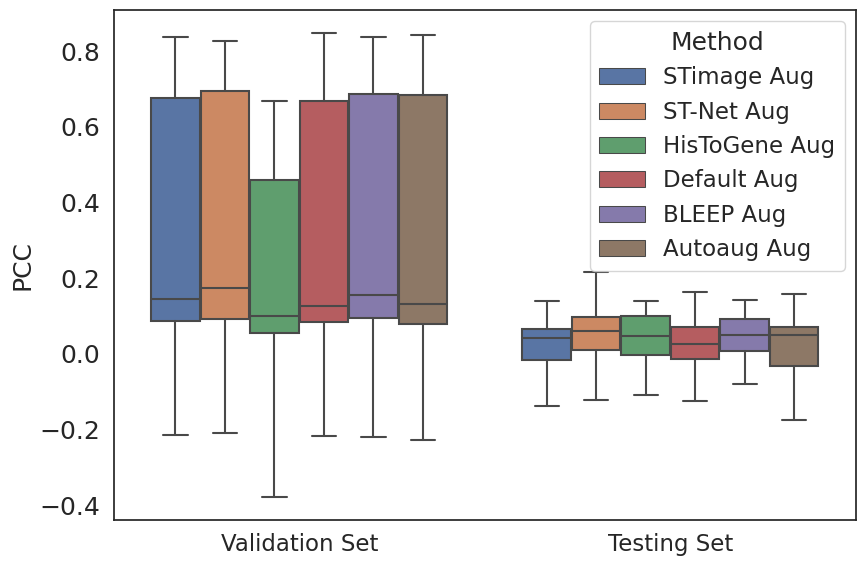

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch

fig = plt.figure(figsize=(9, 6))
sns.set(font_scale=1.5)
sns.set_style("white")
ax = sns.boxplot(x="Kind", y="Pearson correlation",hue="Method", data=OOD , showfliers=False, orient="v")   
sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 1))
plt.xlabel("")
plt.ylabel("PCC")
# plt.title("Assessment of Hist2ST's generalization capability under different \n software's augmentation method (Visium dataset)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.xticks([0, 1], ['Validation Set', 'Testing Set'])
plt.yticks(fontsize=18)

# plt.autoscale()
plt.tight_layout()
# plt.savefig("./Software_aug_comparison.png", dpi=200)
plt.show()

In [3]:
!squeue -u uqyjia11

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            578960       gpu Regclass uqyjia11  R    1:59:25      1 gpunode-1-8


In [ ]:
!scancel 578960